In [1]:
import datetime
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from datetime import datetime, timedelta

In [146]:
test=get_variable(domain='lnd',var='BTRAN2',h='h0',runname='COUP0000_PI_SOM')['BTRAN2']

In [96]:
test#.mean(dim='time').plot()

<xarray.DataArray 'H2OSOI' (time: 1680, levsoi: 20, lat: 96, lon: 144)>
dask.array<open_dataset-e97623ef59b502c2110b7cb524433c0eH2OSOI, shape=(1680, 20, 96, 144), dtype=float32, chunksize=(1680, 20, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * levsoi   (levsoi) float32 0.01 0.04 0.09 0.16 0.26 ... 5.06 5.95 6.94 8.03
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.10526 -86.210526 ... 88.10526 90.0
  * time     (time) object 0049-02-01 00:00:00 ... 0189-01-01 00:00:00
Attributes:
    long_name:     volumetric soil water (natural vegetated and crop landunit...
    units:         mm3/mm3
    cell_methods:  time: mean

In [2]:
def get_variable(domain='atm',var='TREFHT',h='h1',runname='COUP0000_PI_SOM'):
    if var=='RESTOM':
        fsnt = get_variable(domain='atm',var='FSNT',h=h,runname=runname)
        flnt = get_variable(domain='atm',var='FLNT',h=h,runname=runname)
        ds=fsnt
        ds['RESTOM'] = fsnt.FSNT-flnt.FLNT
    else:
        fpath = '/glade/campaign/cgd/tss/people/czarakas/CoupledPPE/coupled_simulations/'+runname+'/'+domain+'/proc/tseries/month_1/'
        fname = fpath+'*'+h+'.'+var+'.*.nc'
        #print(fname)
        ds = xr.open_mfdataset(fname, combine='by_coords')
    return ds

In [3]:
ds1=xr.open_dataset('/glade/campaign/cgd/tss/people/czarakas/CoupledPPE/coupled_simulations/COUP0000_PI_SOM/atm/hist/COUP0000_PI_SOM.cam.h0.0093-01.nc')
ds2=xr.open_dataset('/glade/campaign/cgd/tss/people/czarakas/CoupledPPE/coupled_simulations/COUP0000_PI_SOM/lnd/hist/COUP0000_PI_SOM.clm2.h1.0089-02-01-00000.nc')


# Calculate area weights

In [4]:
import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils')

from load_ensembles import *
from load_gridcell_areas import *

In [5]:
def global_avg_atm(ds, var):
    #coslat = np.cos(np.deg2rad(ds.lat))
    #atm_weights = coslat / coslat.mean(dim='lat') 
    
    atm_weights = weight_factor2 #weight_factor2/weight_factor2.mean(dim='lat') 
    
    return (ds[var]*atm_weights).mean(dim=['lat','lon'])

In [6]:
def days_in_month(nyears, ds):
    '''
    returns an xr.DataArray of days per month, tiled for nyears
    '''
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    da = xr.DataArray(np.tile(days_pm,nyears),dims='time')
    da['time']=ds['time']
    return da

In [7]:
def weighted_temporal_mean(ds, var):
    """
    weight by days in each month
    """
    # Determine the month length
    nyears=int(np.size(ds.time)/12)
    month_length = days_in_month(nyears, ds)

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

### Shared plotting settings

In [8]:
simlist=[]
for key in crosswalk.Key_short.values:
    simlist.append('COUP'+key+'_PI_SOM_v02')

In [9]:
colors=['goldenrod',
        'goldenrod',
        'skyblue',
        'skyblue',
        'skyblue',
        'skyblue',
        '#6CD3E9',
        '#6CD3E9',
        'skyblue',
        'skyblue',
        '#F9CCAD',
        '#F9CCAD',
        'teal',
        'teal',
        'forestgreen',
        'forestgreen',
        'forestgreen',
        'forestgreen',
        'forestgreen',
        'teal',
        'teal',
        'orange',
        'orange',
        'lightseagreen',
        'lightseagreen',
        'teal',
        'forestgreen',
        'teal',
        'skyblue',
        'skyblue',
        'purple',
        'purple',
        'purple',
        'purple',
        'purple',
        'purple']

## Subplot a

In [73]:
def get_tseries(var_to_check, spinup_end_yr=40, domain='lnd',nonglac=False, h='h1'):
    da_annual_globals=[]
    da_annual_global_means=[]
    slopes=[]
    pvals=[]
    
    for i, sim in enumerate(simlist):
        ds2 = get_variable(domain=domain,var=var_to_check,h=h,runname=sim)
        ds2['time']=ds2['time']-timedelta(days = 15)

        da2=ds2[var_to_check]
        da_annual2=weighted_temporal_mean(ds2,var_to_check)
        if domain=='lnd':
            if nonglac:
                da_annual_global2=(da_annual2*landweights_nonglac2).sum(dim=['lat','lon']).load()
            else:
                da_annual_global2=(da_annual2*landweights2).sum(dim=['lat','lon']).load()
        elif domain=='atm':
            weight_factor2 = ds2.gw / ds2.gw.mean(dim='lat')
            da_annual_global2=(da_annual2*weight_factor2).mean(dim=['lat','lon']).load()
        da_annual_globals.append(da_annual_global2)
        #print(sim)
        meantemp=(np.nanmean(da_annual_global2[spinup_end_yr:]))
        da_annual_global_means.append(meantemp)

        [slope, intercept, r_value, p_value, std_err] = stats.linregress(da_annual_global2['time.year'][spinup_end_yr:],
                                                                     da_annual_global2[spinup_end_yr:])
        slopes.append(slope)
        pvals.append(p_value)
        #if p_value<=0.05:
            #print(slope)
            #print(p_value)
    return [da_annual_globals, da_annual_global_means, slopes, pvals]

In [12]:
[da_annual_globals_TLAI, 
 da_annual_global_means_TLAI, 
 slopes_TLAI, 
 pvals_TLAI]=get_tseries(var_to_check='TLAI', 
                                                                       spinup_end_yr=40, 
                                                                       domain='lnd',
                        nonglac=True)

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/

In [74]:
[da_annual_globals_BTRAN2, 
 da_annual_global_means_BTRAN2, 
 slopes_BTRAN2, 
 pvals_BTRAN2]=get_tseries(var_to_check='BTRAN2', 
                                                                       spinup_end_yr=40, 
                                                                       domain='lnd',
                        nonglac=True)

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


KeyboardInterrupt: 

In [75]:
[da_annual_globals_SOILWATER_10CM, 
 da_annual_global_means_SOILWATER_10CM, 
 slopes_SOILWATER_10CM, 
 pvals_SOILWATER_10CM]=get_tseries(var_to_check='SOILWATER_10CM', 
                                                                       spinup_end_yr=40, 
                                                                       domain='lnd',h='h0',
                        nonglac=True)

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/

In [ ]:
[da_annual_globals_TLAI, 
 da_annual_global_means_TLAI, 
 slopes_TLAI, 
 pvals_TLAI]=get_tseries(var_to_check='TLAI', 
                                                                       spinup_end_yr=40, 
                                                                       domain='lnd',
                        nonglac=True)

In [13]:
[da_annual_globals_TSKIN, 
 da_annual_global_means_TSKIN, 
 slopes_TSKIN, 
 pvals_TSKIN]=get_tseries(var_to_check='TSKIN', 
                                                                       spinup_end_yr=40, 
                                                                       domain='lnd')

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/ncar/usr/

In [14]:
[da_annual_globals_TS, 
 da_annual_global_means_TS, 
 slopes_TS, 
 pvals_TS]=get_tseries(var_to_check='TS', 
                                                                       spinup_end_yr=40, 
                                                                       domain='atm')
da_annual_globals_TS=da_annual_globals_TS
da_annual_global_means_TS=da_annual_global_means_TS

In [15]:
var_to_check='TS'
ds = get_variable(domain='atm',var=var_to_check,h='h0',runname='COUP0000_PI_SOM')
weight_factor = ds.gw / ds.gw.mean(dim='lat')
ds['time']=ds['time']-timedelta(days = 15)

da=ds[var_to_check]
da_annual_TS=weighted_temporal_mean(ds,var_to_check)
da_annual_global_TS=(da_annual_TS*weight_factor).mean(dim=['lat','lon']).load()

In [16]:
var_to_check='TSKIN'
ds = get_variable(domain='lnd',var=var_to_check,h='h0',runname='COUP0000_PI_SOM')
ds['time']=ds['time']-timedelta(days = 15)

da=ds[var_to_check]
da_annual_TSKIN=weighted_temporal_mean(ds,var_to_check)
da_annual_global_TSKIN=(da_annual_TSKIN*landweights2).sum(dim=['lat','lon']).load()

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


In [17]:
var_to_check='TLAI'
ds = get_variable(domain='lnd',var=var_to_check,h='h0',runname='COUP0000_PI_SOM')
ds['time']=ds['time']-timedelta(days = 15)

da=ds[var_to_check]
da_annual_TLAI=weighted_temporal_mean(ds,var_to_check)
da_annual_global_TLAI=(da_annual_TLAI*landweights_nonglac2).sum(dim=['lat','lon']).load()

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


In [58]:
var_to_check='BTRAN2'
ds = get_variable(domain='lnd',var=var_to_check,h='h0',runname='COUP0000_PI_SOM')
ds['time']=ds['time']-timedelta(days = 15)

da=ds[var_to_check]
da_annual_BTRAN2=weighted_temporal_mean(ds,var_to_check)
da_annual_global_BTRAN2=(da_annual_BTRAN2*landweights_nonglac2).sum(dim=['lat','lon']).load()

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


In [70]:
var_to_check='SOILWATER_10CM'
ds = get_variable(domain='lnd',var=var_to_check,h='h0',runname='COUP0000_PI_SOM')
ds['time']=ds['time']-timedelta(days = 15)

da=ds[var_to_check]
da_annual_SOILWATER_10CM=weighted_temporal_mean(ds,var_to_check)
da_annual_global_SOILWATER_10CM=(da_annual_SOILWATER_10CM*landweights_nonglac2).sum(dim=['lat','lon']).load()

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


In [59]:
da_annual_global_mean_TLAI=da_annual_global_TLAI[40:].mean(dim='time')
da_annual_global_mean_TS=da_annual_global_TS[40:].mean(dim='time')
da_annual_global_mean_TSKIN=da_annual_global_TSKIN[40:].mean(dim='time')
da_annual_global_mean_BTRAN2=da_annual_global_BTRAN2[40:].mean(dim='time')

In [71]:
da_annual_global_mean_SOILWATER_10CM=da_annual_global_SOILWATER_10CM[40:].mean(dim='time')

# Make plots

In [136]:
def convert_units(da, varname='TS'):
    if varname in ['TS','TSKIN','TREFHT']:
        da_converted=da-273.15
    else:
        da_converted=da
    return da_converted

In [144]:
var_to_check='TLAI'
if var_to_check=='TLAI':
    da_annual_globals=da_annual_globals_TLAI
    da_annual_global=da_annual_global_TLAI
elif var_to_check=='TS':
    da_annual_globals=da_annual_globals_TS
    da_annual_global=da_annual_global_TS
elif var_to_check=='TSKIN':
    da_annual_globals=da_annual_globals_TSKIN
    da_annual_global=da_annual_global_TSKIN
elif var_to_check=='BTRAN2':
    da_annual_globals=da_annual_globals_BTRAN2
    da_annual_global=da_annual_global_BTRAN2
elif var_to_check=='SOILWATER_10CM':
    da_annual_globals=da_annual_globals_SOILWATER_10CM
    da_annual_global=da_annual_global_SOILWATER_10CM
    
ref_da_annual_global_mean=da_annual_global.mean(dim='time')

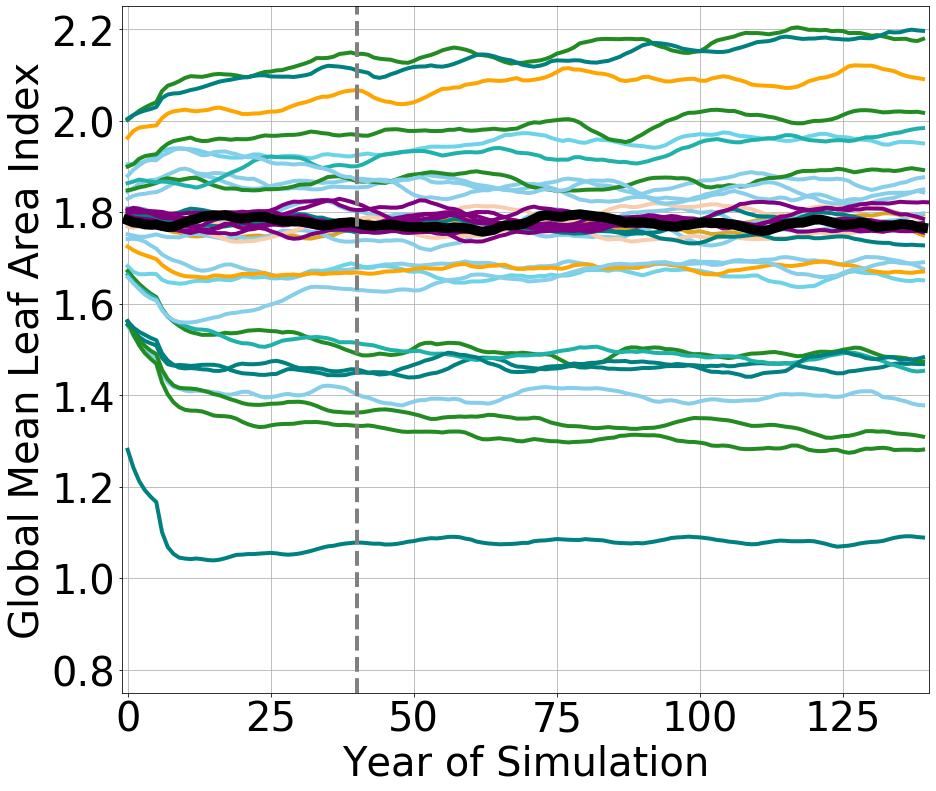

In [145]:
plt.figure(figsize=(14,12))
years=np.arange(0,140)
avg_period=10
plt.rcParams.update({'font.size': 40})

tseries_ref=convert_units(da_annual_global, varname=var_to_check)

for i, sim in enumerate(simlist):
    tseries=convert_units(da_annual_globals[i], varname=var_to_check)
    plt.plot(tseries.rolling(time=avg_period,min_periods=1, center=True).mean(),
             color=colors[i], linewidth=4)
plt.plot(tseries_ref.rolling(time=avg_period,min_periods=1,center=True).mean(),'-k',linewidth=10)
plt.xlim([-1,140])
plt.grid()
plt.axvline(x=40,linestyle='--',color='gray',linewidth=4)
plt.tight_layout()
if var_to_check=='TLAI':
    plt.ylabel('Global Mean Leaf Area Index')
    plt.ylim([0.75,2.25])
elif var_to_check=='TS':
    plt.ylabel('Global Mean Skin Temperature (C)')
    plt.ylim([15.5,17.5])
elif var_to_check=='TSKIN':
    plt.ylabel('Global Mean Nonglaciated \n Land Skin Temperature (C)')
    plt.ylim([9,12])
elif var_to_check=='BTRAN2':
    plt.ylabel('Global Mean Nonglaciated \n Root Soil Wetness Factor')
    plt.ylim([0.67,0.75])
elif var_to_check=='SOILWATER_10CM':
    plt.ylabel('Water in Top 10 cm of Soil (kg/m2)')
plt.xlabel('Year of Simulation')
plt.tight_layout()
plt.savefig('Figures/Figure_S_'+var_to_check+'.pdf')

# Other 

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  app.launch_new_instance()


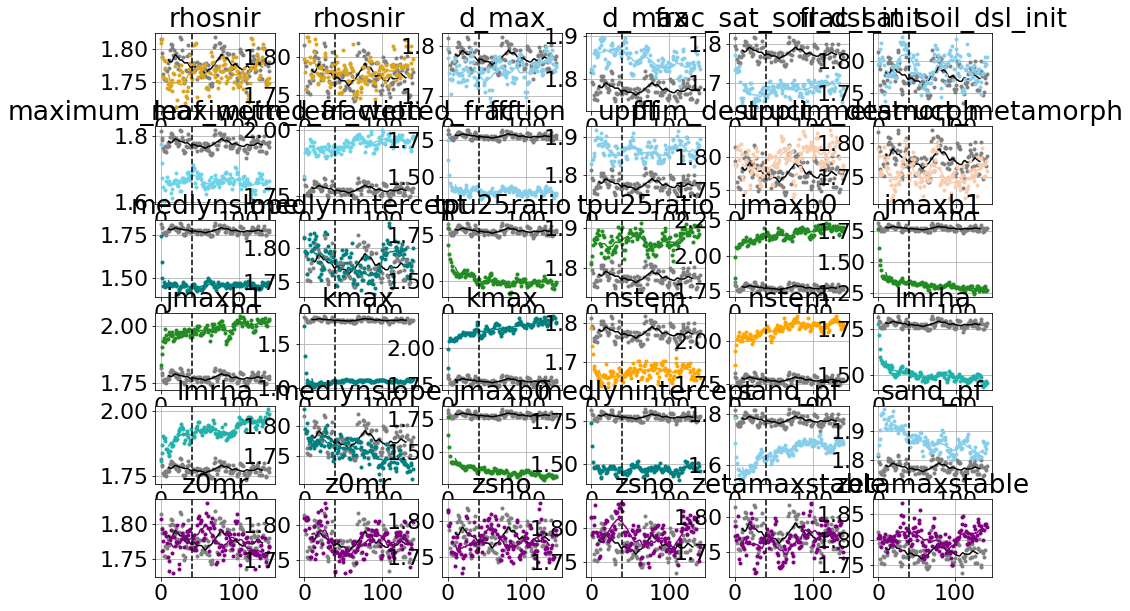

In [65]:

plt.figure(figsize=(15,10))
years=np.arange(0,140)
for i, sim in enumerate(simlist):
    plt.subplot(6,6,i+1)
    plt.plot(da_annual_global,'.',color='gray',linewidth=0.5)
    plt.plot(da_annual_global.rolling(time=20, center=True).mean(),'-k')
    plt.plot(da_annual_globals[i],'.',color=colors[i],linewidth=0.5)
    plt.plot(da_annual_globals[i].rolling(time=20, center=True).mean(),'-',
             color=colors[i])
    
    y=da_annual_globals[i][40:140]
    x=da_annual_globals[i]['time.year'][40:140]
    plt.grid()
    plt.axvline(x=40,linestyle='--',color='k')
    plt.title(crosswalk.param.values[i])
plt.tight_layout()

In [18]:
ds_check=xr.open_mfdataset('/glade/campaign/univ/uwas0044/czarakas/StomatalSlopeExperiments2021/archive/coupled/coupled_DEFmedslope_1xCO2_03/atm/hist/'+
                           'coupled_DEFmedslope_1xCO2_03.cam.h0.007*.nc')

In [19]:
print(np.nanmean(ds_check.n2ovmr*1e9))

275.67999999999995


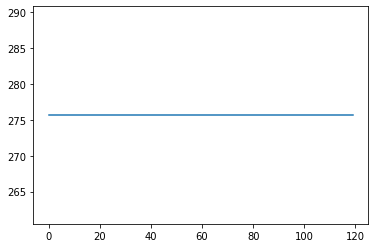

In [20]:
plt.plot(ds_check.n2ovmr*1e9)

In [22]:
#ds_trefht=xr.open_dataset('/glade/campaign/univ/uwas0044/czarakas/StomatalSlopeExperiments2021/archive/spinup_coupled/coupled_DEFmedslope_1xCO2_02_old/tseries/'+
#                          'coupled_DEFmedslope_1xCO2_02.cam.h0.TREFHT.000101-004012.nc')
#ds_trefht=xr.open_dataset('/glade/campaign/univ/uwas0044/czarakas/StomatalSlopeExperiments2021/archive/coupled/coupled_DEFmedslope_1xCO2_03/atm/proc/tseries/'+
#                          'coupled_DEFmedslope_1xCO2_03.cam.h0.timeseries.TREFHT.nc')

In [7]:
ds_trefht=get_variable(domain='atm',var='TREFHT',h='h1')
trefht_glb=global_avg_atm(ds_trefht, var='TREFHT')[:-1]

In [8]:
tmonths = np.arange(0, np.size(trefht_glb.time))/12
tyears = np.arange(0, np.size(trefht_glb.time.groupby('time.year').mean(dim='time')))+0.5

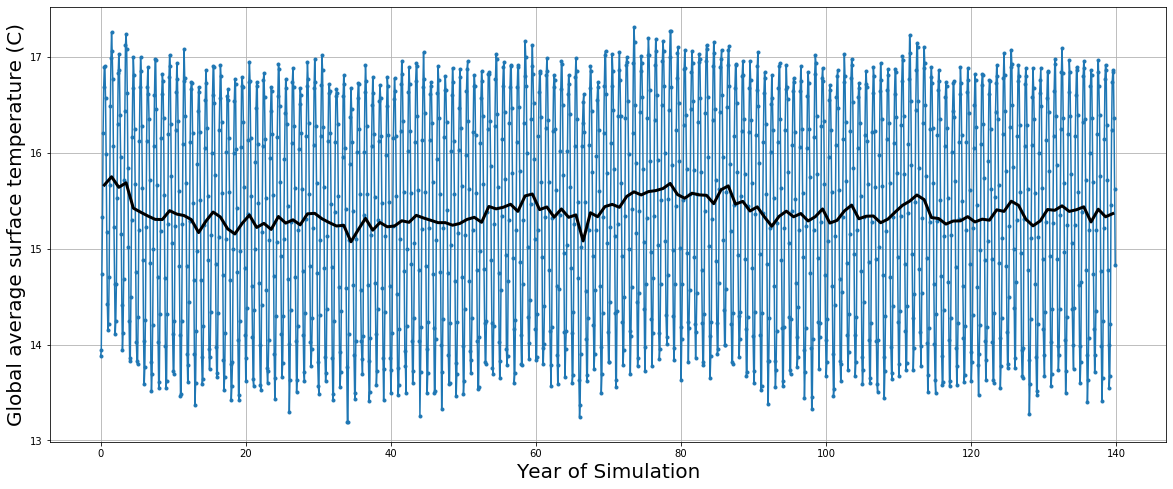

In [9]:
plt.figure(figsize=(20,8))
plt.plot(tmonths, trefht_glb-273.15,'.-')
plt.plot(tyears,trefht_glb.groupby('time.year').mean(dim='time')-273.15,
         '-k',linewidth=3)
plt.xlabel('Year of Simulation', fontsize=20)
plt.ylabel('Global average surface temperature (C)', fontsize=20)
plt.grid()
#plt.xlim([0,20])
plt.savefig('Spinup_global_temperature.png')